# とりあえずモデルの精度検査をする

アノテーションの位置も考慮して、判定すべき物体を認識する。
多分ほぼテストの完成形

## Pythonに上位層を読み込ませる

In [1]:
import sys
sys.path.append('../')

## モジュールインポート

In [ ]:
import os,sys
import argparse
from src.yolo import YOLO
from PIL import Image
import numpy as n
import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import shutil

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## 関数宣言

In [ ]:
def detect_img(img_path):
     
    try:
        image = Image.open(img_path)
    except:
        print('Open Image Error:', img_path)
        return None, None
    else:
        r_image, result = yolo.detect_image(image)
        
    return r_image, result

In [3]:
def search_bbox(bbox, result_list):
    iou_max = 0
    iou_index = None
    for i, result in enumerate(result_list):
        if result[2] == None:
            continue
        iou =get_iou(bbox, result[1:5])
        if iou > iou_max:
            iou_max = iou
            iou_index = i
    return iou_index

In [4]:
def get_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = abs(xB - xA) * abs(yB - yA)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0])) * abs((boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0])) * abs((boxB[3] - boxB[1]))
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

## モデルデータ宣言

In [5]:
model_path = 'logs/種類モデル20200723/2020-07-23_20:05:37.439628/trained_weights_final.h5'
class_path = 'model_data/種類モデル/class.txt'

## アウトプット先フォルダ宣言

In [6]:
outputPath = 'テスト結果'

### yoloインスタンス作成

In [7]:
yolo = YOLO(model_path=model_path, classes_path=class_path)

Instructions for updating:
Colocations handled automatically by placer.
logs/種類モデル20200723/2020-07-23_20:05:37.439628/trained_weights_final.h5 model, anchors, and classes loaded.


## テストファイル(テストデータのパスリスト)を読み込んでインプットとなる配列とアウトプットとなるクラス配列を作成

In [8]:
test_file = '../テストデータ/random_100/test.txt'

In [9]:
test_x = []
test_y = []
bbox_list = []
with open(test_file, 'r', encoding='utf-8') as f:
    line = f.readline()
    while line:
        line = line.split(" ")
        test_x.append(line[0])
        test_y.append(int(line[1].split(",")[-1].replace("\n", "")))
        bbox_list.append([int(num.replace("\n", "")) for num in line[1].split(",")[:-1]])
        line = f.readline()

In [10]:
print(test_x)
print(test_y)
print(bbox_list)

['../テストデータ/random_1000/image/573.jpg', '../テストデータ/random_1000/image/658.jpg', '../テストデータ/random_1000/image/843.jpg', '../テストデータ/random_1000/image/971.jpg', '../テストデータ/random_1000/image/49.jpg', '../テストデータ/random_1000/image/753.jpg', '../テストデータ/random_1000/image/1085.jpg', '../テストデータ/random_1000/image/352.jpg', '../テストデータ/random_1000/image/780.jpg', '../テストデータ/random_1000/image/1126.jpg', '../テストデータ/random_1000/image/752.jpg', '../テストデータ/random_1000/image/708.jpg', '../テストデータ/random_1000/image/700.jpg', '../テストデータ/random_1000/image/139.jpg', '../テストデータ/random_1000/image/706.jpg', '../テストデータ/random_1000/image/62.jpg', '../テストデータ/random_1000/image/498.jpg', '../テストデータ/random_1000/image/1449.jpg', '../テストデータ/random_1000/image/738.jpg', '../テストデータ/random_1000/image/701.jpg', '../テストデータ/random_1000/image/694.jpg', '../テストデータ/random_1000/image/480.jpg', '../テストデータ/random_1000/image/123.jpg', '../テストデータ/random_1000/image/144.jpg', '../テストデータ/random_1000/image/398.jpg', '../テストデータ/random_1000/

## クラスファイル読み込み

In [11]:
class_list = []
with open(class_path, 'r') as f:
    line = f.readline()
    while line:
        class_list.append(line.replace("\n",""))
        line = f.readline()

In [12]:
print(class_list)

['リンゴ', '梨', 'ミカン', 'イチゴ', 'ブドウ', '桃', 'さくらんぼ']


## クラスファイルに読み込み失敗を追加

In [13]:
class_list.append('failed')
print(class_list)

['リンゴ', '梨', 'ミカン', 'イチゴ', 'ブドウ', '桃', 'さくらんぼ', 'failed']


## 画像認識を回してく

In [ ]:
result_list = []
for path in test_x:
    image, result = detect_img(path)
    if not result or len(result) == 0:
        result = [[class_list.index(class_list[-1]), None, None, None, None, None]]
    else:
        for r in result:
            r[0] = class_list.index(r[0])
    result_list.append({
        "image": image,
        "result": result
    })

(416, 416, 3)
Found 2 boxes for img
ミカン 1.00 (18, 351) (143, 476)
ミカン 1.00 (85, 81) (378, 356)
5.422840782999998
(416, 416, 3)
Found 3 boxes for img
ミカン 1.00 (211, 164) (452, 386)
ミカン 1.00 (241, 17) (478, 225)
ミカン 1.00 (24, 79) (245, 314)
0.11452059199999098
(416, 416, 3)
Found 8 boxes for img
イチゴ 0.40 (167, 8) (241, 86)
イチゴ 0.57 (91, 23) (156, 96)
イチゴ 0.95 (217, 58) (293, 124)
イチゴ 0.96 (124, 65) (209, 144)
イチゴ 0.97 (219, 115) (303, 204)
イチゴ 0.97 (27, 69) (117, 132)
イチゴ 0.98 (47, 121) (139, 217)
イチゴ 1.00 (130, 152) (224, 246)
0.1329992390000143
(416, 416, 3)
Found 4 boxes for img
イチゴ 0.99 (505, 769) (990, 1018)
イチゴ 1.00 (660, 333) (1024, 821)
イチゴ 1.00 (386, 163) (779, 660)
イチゴ 1.00 (183, 511) (626, 1012)
0.14817115400001057
(416, 416, 3)
Found 2 boxes for img
リンゴ 0.99 (73, 55) (302, 304)
リンゴ 1.00 (293, 87) (521, 351)
0.12303912400000172
(416, 416, 3)
Found 2 boxes for img
イチゴ 1.00 (307, 479) (1094, 1247)
イチゴ 1.00 (946, 196) (1699, 1035)
0.16206787000001555
(416, 416, 3)
Found 1 boxes f

Found 2 boxes for img
ミカン 1.00 (346, 104) (668, 439)
ミカン 1.00 (6, 95) (341, 409)
0.12521503800002165
(416, 416, 3)
Found 1 boxes for img
ミカン 1.00 (1, 184) (333, 515)
0.12038193999998725
(416, 416, 3)
Found 8 boxes for img
イチゴ 0.44 (609, 244) (1035, 658)
イチゴ 0.44 (185, 264) (604, 649)
イチゴ 0.82 (3, 641) (410, 997)
イチゴ 0.83 (0, 988) (271, 1479)
イチゴ 0.93 (237, 897) (670, 1351)
イチゴ 0.96 (354, 577) (802, 910)
イチゴ 0.99 (603, 841) (1100, 1247)
イチゴ 1.00 (428, 1186) (1077, 1799)
0.1863994059999925
(416, 416, 3)
Found 1 boxes for img
ミカン 1.00 (58, 96) (286, 299)
0.10712802200001192
(416, 416, 3)
Found 2 boxes for img
リンゴ 1.00 (500, 77) (936, 511)
リンゴ 1.00 (72, 88) (506, 555)
0.1266612180000095
(416, 416, 3)
Found 3 boxes for img
リンゴ 0.96 (369, 202) (578, 377)
リンゴ 0.99 (24, 171) (258, 382)
リンゴ 1.00 (249, 50) (416, 229)
0.13385937299997863
(416, 416, 3)
Found 3 boxes for img
リンゴ 0.98 (1682, 584) (2565, 1326)
リンゴ 0.99 (1993, 1129) (2946, 1962)
リンゴ 1.00 (889, 948) (1805, 1860)
0.2550930729999834
(416

Found 2 boxes for img
梨 0.93 (35, 34) (217, 224)
梨 1.00 (184, 36) (396, 266)
0.11098344099997348
(416, 416, 3)
Found 1 boxes for img
ミカン 1.00 (366, 7) (854, 543)
0.12753989900002694
(416, 416, 3)
Found 1 boxes for img
さくらんぼ 0.80 (81, 6) (398, 289)
0.11157535099999905
(416, 416, 3)
Found 1 boxes for img
ブドウ 1.00 (102, 40) (632, 498)
0.12814547499999662
(416, 416, 3)
Found 3 boxes for img
ミカン 0.47 (672, 291) (943, 522)
ミカン 0.99 (0, 408) (370, 723)
ミカン 1.00 (293, 297) (767, 700)
0.15809795300000928
(416, 416, 3)
Found 1 boxes for img
ブドウ 1.00 (31, 24) (327, 440)
0.10670228600000087
(416, 416, 3)
Found 1 boxes for img
リンゴ 1.00 (191, 108) (1276, 1170)
0.15765445499999942
(416, 416, 3)
Found 5 boxes for img
リンゴ 0.96 (12, 860) (549, 1411)
リンゴ 0.99 (585, 893) (1125, 1474)
リンゴ 1.00 (419, 28) (903, 499)
リンゴ 1.00 (29, 302) (525, 836)
リンゴ 1.00 (713, 397) (1276, 915)
0.18326047300001846
(416, 416, 3)
Found 1 boxes for img
リンゴ 1.00 (0, 113) (582, 679)
0.10876656500002468
(416, 416, 3)
Found 1 boxes 

Found 1 boxes for img
ブドウ 1.00 (257, 66) (534, 519)
0.1303217669999981
(416, 416, 3)
Found 8 boxes for img
ミカン 0.33 (7, 184) (177, 287)
ミカン 0.91 (118, 514) (402, 631)
ミカン 0.92 (416, 216) (617, 443)
ミカン 0.93 (0, 0) (212, 127)
ミカン 0.97 (3, 205) (176, 532)
ミカン 1.00 (103, 8) (323, 238)
ミカン 1.00 (352, 2) (598, 231)
ミカン 1.00 (218, 268) (539, 599)
0.1334618310000053
(416, 416, 3)
Found 3 boxes for img
桃 0.85 (78, 534) (183, 615)
桃 0.98 (319, 143) (510, 345)
桃 1.00 (58, 222) (366, 491)
0.12304697300001521
(416, 416, 3)
Found 3 boxes for img
梨 0.98 (326, 401) (558, 650)
梨 1.00 (74, 378) (339, 607)
梨 1.00 (549, 364) (791, 601)
0.13289172199998234
(416, 416, 3)
Found 8 boxes for img
さくらんぼ 0.33 (4, 106) (146, 206)
さくらんぼ 0.34 (347, 17) (587, 193)
さくらんぼ 0.35 (510, 518) (673, 766)
さくらんぼ 0.46 (133, 616) (400, 825)
さくらんぼ 0.53 (2, 100) (150, 352)
さくらんぼ 0.61 (0, 17) (269, 187)
さくらんぼ 0.64 (250, 207) (573, 393)
さくらんぼ 0.68 (394, 0) (516, 109)
0.14938195499999551
(416, 416, 3)
Found 5 boxes for img
イチゴ 0.91 

Found 3 boxes for img
桃 1.00 (319, 82) (659, 551)
桃 1.00 (149, 665) (658, 991)
桃 1.00 (17, 290) (541, 832)
0.14340723499998376
(416, 416, 3)
Found 2 boxes for img
イチゴ 1.00 (278, 24) (481, 322)
イチゴ 1.00 (48, 46) (299, 313)
0.11846612299999038
(416, 416, 3)
Found 1 boxes for img
ブドウ 1.00 (15, 69) (643, 472)
0.11119237900001622
(416, 416, 3)
Found 6 boxes for img
リンゴ 0.41 (312, 100) (470, 242)
リンゴ 0.52 (184, 88) (295, 183)
リンゴ 0.92 (3, 128) (189, 313)
リンゴ 0.97 (272, 36) (388, 143)
リンゴ 0.99 (185, 131) (341, 305)
リンゴ 1.00 (41, 5) (224, 178)
0.12993686499999058
(416, 416, 3)
Found 3 boxes for img
さくらんぼ 0.45 (57, 193) (522, 651)
ミカン 0.75 (68, 238) (510, 672)
梨 0.36 (68, 238) (510, 672)
0.13442964999998708
(416, 416, 3)
Found 1 boxes for img
桃 1.00 (8, 2) (290, 285)
0.12209445900001015
(416, 416, 3)
Found 4 boxes for img
リンゴ 0.92 (285, 57) (398, 177)
リンゴ 0.97 (135, 44) (318, 217)
リンゴ 0.98 (416, 195) (579, 380)
リンゴ 0.99 (239, 169) (447, 372)
0.12959332500000187
(416, 416, 3)
Found 3 boxes for i

Found 1 boxes for img
イチゴ 0.68 (313, 359) (632, 746)
0.1320629919999874
(416, 416, 3)
Found 1 boxes for img
ミカン 1.00 (84, 11) (365, 290)
0.11453364800001964
(416, 416, 3)
Found 2 boxes for img
さくらんぼ 0.42 (18, 67) (263, 288)
さくらんぼ 0.84 (420, 17) (737, 431)
0.1404410430000098
(416, 416, 3)
Found 4 boxes for img
リンゴ 0.32 (84, 162) (247, 302)
リンゴ 0.32 (412, 122) (589, 290)
リンゴ 0.39 (121, 16) (298, 165)
リンゴ 0.99 (174, 190) (407, 386)
0.12624285300000793
(416, 416, 3)
Found 2 boxes for img
ミカン 1.00 (51, 74) (300, 315)
ミカン 1.00 (303, 37) (544, 289)
0.12120120099999099
(416, 416, 3)
Found 3 boxes for img
梨 1.00 (1101, 398) (1758, 906)
梨 1.00 (556, 564) (1184, 1120)
梨 1.00 (646, 143) (1217, 631)
0.18063644200000795
(416, 416, 3)
Found 1 boxes for img
梨 0.99 (57, 58) (350, 340)
0.11517262499998537
(416, 416, 3)
Found 3 boxes for img
ミカン 1.00 (349, 55) (704, 404)
ミカン 1.00 (597, 187) (1123, 705)
ミカン 1.00 (61, 233) (633, 786)
0.14724204699999177
(416, 416, 3)
Found 1 boxes for img
梨 1.00 (462, 160)

Found 1 boxes for img
リンゴ 1.00 (30, 30) (260, 269)
0.10167937800000004
(416, 416, 3)
Found 1 boxes for img
イチゴ 1.00 (32, 129) (441, 665)
0.12948421800001597
(416, 416, 3)
Found 1 boxes for img
ミカン 1.00 (506, 17) (969, 425)
0.1440972620000025
(416, 416, 3)
Found 1 boxes for img
イチゴ 1.00 (640, 575) (1288, 1467)
0.17753560100001664
(416, 416, 3)
Found 1 boxes for img
ブドウ 0.99 (166, 39) (586, 318)
0.1267380879999962
(416, 416, 3)
Found 1 boxes for img
梨 1.00 (57, 10) (581, 482)
0.1325700769999969
(416, 416, 3)
Found 1 boxes for img
さくらんぼ 0.57 (0, 1) (406, 249)
0.13228454699998338
(416, 416, 3)
Found 2 boxes for img
桃 1.00 (43, 101) (252, 322)
桃 1.00 (108, 216) (367, 477)
0.12675705600000242
(416, 416, 3)
Found 2 boxes for img
ミカン 0.93 (1030, 349) (1647, 795)
リンゴ 0.99 (339, 155) (1037, 815)
0.1685609920000104
(416, 416, 3)
Found 1 boxes for img
ブドウ 1.00 (0, 0) (542, 720)
0.11941384799999355
(416, 416, 3)
Found 1 boxes for img
ミカン 1.00 (231, 87) (811, 625)
0.12985486499999865
(416, 416, 3)
F

Found 2 boxes for img
リンゴ 0.70 (0, 0) (150, 206)
リンゴ 0.82 (57, 11) (396, 352)
0.11796025199998894
(416, 416, 3)
Found 3 boxes for img
ブドウ 0.73 (295, 15) (320, 72)
ブドウ 0.92 (31, 80) (94, 184)
ブドウ 0.96 (94, 116) (221, 252)
0.11863042999999607
(416, 416, 3)
Found 1 boxes for img
ブドウ 1.00 (70, 32) (539, 1054)
0.13984600700001693
(416, 416, 3)
Found 6 boxes for img
イチゴ 0.42 (331, 101) (391, 196)
イチゴ 0.55 (300, 222) (392, 327)
イチゴ 0.94 (236, 126) (343, 238)
イチゴ 0.96 (670, 244) (797, 448)
イチゴ 0.98 (553, 268) (683, 495)
イチゴ 0.98 (339, 311) (482, 505)
0.13611441700004434
(416, 416, 3)
Found 3 boxes for img
イチゴ 1.00 (230, 86) (722, 573)
イチゴ 1.00 (60, 302) (765, 983)
イチゴ 1.00 (717, 169) (1000, 793)
0.1438079969999535
(416, 416, 3)
Found 1 boxes for img
リンゴ 1.00 (87, 64) (498, 428)
0.12561159099999486
(416, 416, 3)
Found 6 boxes for img
イチゴ 0.49 (385, 118) (624, 348)
イチゴ 0.97 (406, 495) (651, 739)
イチゴ 0.99 (741, 78) (1007, 360)
イチゴ 0.99 (9, 77) (308, 346)
イチゴ 1.00 (12, 449) (304, 765)
イチゴ 1.00 (72

Found 5 boxes for img
リンゴ 0.34 (226, 105) (350, 307)
リンゴ 0.94 (136, 231) (332, 348)
リンゴ 0.95 (17, 127) (109, 215)
リンゴ 0.98 (73, 38) (268, 238)
リンゴ 0.98 (2, 196) (135, 329)
0.1226778689999719
(416, 416, 3)
Found 4 boxes for img
さくらんぼ 0.54 (180, 378) (332, 499)
さくらんぼ 0.63 (0, 31) (114, 312)
さくらんぼ 0.86 (224, 41) (499, 457)
さくらんぼ 0.87 (198, 4) (363, 262)
0.13107817200000227
(416, 416, 3)
Found 1 boxes for img
リンゴ 0.99 (259, 13) (460, 213)
0.11734755200001246
(416, 416, 3)
Found 1 boxes for img
さくらんぼ 1.00 (164, 7) (412, 557)
0.12944149100002278
(416, 416, 3)
Found 2 boxes for img
イチゴ 0.98 (645, 301) (1006, 710)
イチゴ 0.99 (283, 382) (675, 856)
0.16297286200000372
(416, 416, 3)
Found 2 boxes for img
梨 1.00 (369, 31) (626, 278)
梨 1.00 (129, 208) (439, 463)
0.12605688000002147
(416, 416, 3)
Found 3 boxes for img
イチゴ 0.33 (176, 395) (444, 634)
イチゴ 0.99 (399, 407) (698, 660)
イチゴ 1.00 (460, 55) (768, 414)
0.13859128500001816
(416, 416, 3)
Found 1 boxes for img
ブドウ 1.00 (243, 0) (772, 676)
0.1339419

## 結果を可視化&保存

In [16]:
timestamp = datetime.datetime.now()
timestamp = str(timestamp).replace(" ", "_").replace(":", "_")
outputPath = os.path.join(outputPath, timestamp)
os.mkdir(outputPath)
print("folder made:", outputPath)

folder made: テスト結果/2020-07-24_16_32_15.522804


In [17]:
output_test_file = os.path.join(outputPath, os.path.basename(test_file))
shutil.copyfile(test_file, output_test_file)
print("copy", test_file, "to", output_test_file)

copy ../テストデータ/random_1000/test.txt to テスト結果/2020-07-24_16_32_15.522804/test.txt


### アノテーションのiou（Intersection over Union）を計算して正解領域を検索

(例)リストの先頭の画像と、その予測、結果を例にする

../テストデータ/random_1000/image/573.jpg
573.jpg


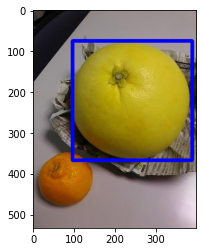

In [18]:
result = result_list[0]['result']
test_image = test_x[0]
print(test_image)
test_image = test_image.split("/")[-1]
print(test_image)
test_image = os.path.join("../train_set/参加者用データ/bbox_image",test_image)
test_image = Image.open(test_image)
plt.imshow(test_image)

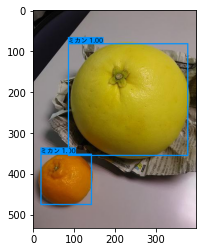

In [19]:
pred_image = result_list[0]['image']
plt.imshow(pred_image)

正解領域と、予測領域を表示

In [20]:
print("正解:",bbox_list[0])
print("予測:",result[0][1:5])

正解: [96, 75, 388, 367]
予測: [18, 351, 143, 476]


iouの値を計算([0 -1])

In [22]:
print(get_iou(bbox_list[0], result[0][1:5]))

0.0075097116949778804


最もiouが高い領域を予測領域から選択する<br>
仮に選択肢が複数あったとする

In [23]:
pre_result = []
import copy
pre_result = copy.copy(result_list[0]['result'])
pre_result.append([0,0,100,200,300,400])
print(pre_result)
index = search_bbox(bbox_list[0], pre_result)
print("最適領域は:",index,"番目")

[[2, 18, 351, 143, 476, 0.99552125], [2, 85, 81, 378, 356, 0.9998294], [0, 0, 100, 200, 300, 400]]
最適領域は: 1 番目


ここから予測結果から最適領域にあるラベルをまとめたリストを作成する

In [24]:
predict_list = []
for i, result in enumerate(result_list):
    
    index = search_bbox(bbox_list[i], result['result'])
    if index is None:
        predict_list.append(result['result'][0][0])
    else:
        predict_list.append(result['result'][index][0])

In [25]:
print(predict_list)

[2, 2, 3, 3, 0, 3, 4, 1, 3, 4, 3, 2, 2, 0, 2, 0, 2, 6, 3, 2, 2, 2, 0, 0, 1, 6, 0, 1, 3, 0, 5, 6, 5, 6, 3, 0, 0, 1, 2, 1, 2, 3, 1, 0, 5, 1, 5, 0, 0, 0, 5, 6, 2, 6, 4, 2, 0, 2, 0, 4, 3, 4, 5, 2, 1, 2, 2, 2, 2, 3, 2, 0, 0, 0, 3, 3, 3, 6, 3, 6, 1, 1, 0, 1, 3, 2, 1, 3, 3, 3, 1, 2, 3, 1, 5, 2, 6, 3, 5, 2, 4, 1, 3, 0, 6, 4, 5, 0, 4, 5, 6, 4, 2, 3, 2, 0, 0, 6, 2, 4, 1, 0, 3, 3, 0, 4, 1, 2, 6, 4, 2, 4, 0, 0, 0, 0, 0, 4, 5, 5, 1, 1, 5, 6, 2, 3, 2, 2, 3, 1, 6, 3, 0, 4, 0, 0, 2, 4, 2, 4, 1, 6, 0, 0, 2, 0, 4, 3, 4, 1, 0, 3, 6, 5, 2, 3, 3, 3, 2, 6, 3, 3, 3, 0, 2, 6, 4, 1, 2, 2, 4, 2, 5, 1, 6, 3, 0, 5, 6, 6, 4, 4, 2, 1, 5, 2, 5, 1, 1, 3, 0, 3, 6, 5, 1, 5, 2, 5, 2, 0, 6, 1, 5, 5, 0, 2, 4, 1, 2, 2, 6, 5, 2, 3, 2, 3, 3, 2, 3, 0, 2, 3, 3, 2, 5, 1, 0, 2, 6, 5, 3, 4, 0, 2, 5, 0, 6, 0, 2, 3, 6, 0, 2, 3, 0, 3, 1, 0, 3, 1, 3, 6, 0, 0, 2, 3, 3, 4, 2, 0, 1, 3, 4, 0, 4, 0, 3, 2, 4, 3, 2, 1, 2, 4, 1, 3, 1, 0, 1, 4, 4, 5, 3, 4, 2, 5, 1, 3, 6, 6, 6, 3, 2, 6, 0, 2, 1, 1, 2, 1, 2, 5, 2, 3, 5, 3, 5, 0, 2, 3, 0, 5, 4, 

In [32]:
if not class_list.index(class_list[-1]) in predict_list:
    class_list = class_list[:-1]
report = classification_report(test_y, predict_list, target_names=class_list)
print(report)
reportFile = os.path.join(outputPath, 'report.txt')
with open (reportFile, 'w', encoding='utf-8') as f:
    f.write(report)

              precision    recall  f1-score   support

         リンゴ       0.99      0.98      0.99       160
           梨       0.97      0.99      0.98       140
         ミカン       0.99      0.99      0.99       183
         イチゴ       1.00      1.00      1.00       182
         ブドウ       1.00      0.99      1.00       122
           桃       0.99      1.00      1.00       104
       さくらんぼ       0.99      0.98      0.99       109
      failed       0.00      0.00      0.00         0

    accuracy                           0.99      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.99      0.99      0.99      1000



/home/buffalokusojima/.pyenv/versions/3.6.8/envs/keras-yolo3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
score = accuracy_score(test_y, predict_list)
print(score)

0.99


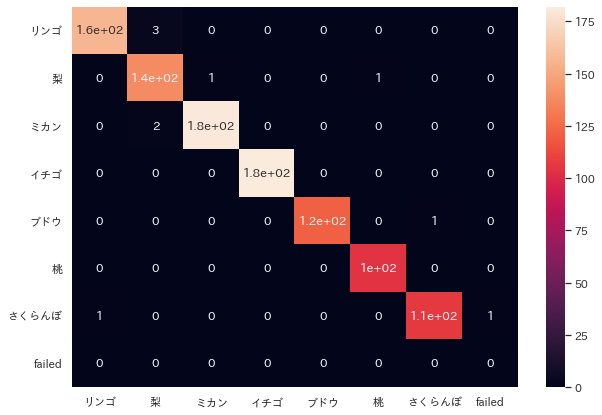

In [34]:
matrix = confusion_matrix(test_y, predict_list)
df_cm = pd.DataFrame(matrix, index=class_list, columns = class_list)
#df_cm = pd.DataFrame(matrix)
plt.figure(figsize=(10,7))
sn.set(font='IPAexGothic')
sn.heatmap(df_cm, annot=True)
confusionFile = os.path.join(outputPath, 'confusionMatrix')
plt.savefig(confusionFile)

### 不正解フォルダを作成して、そこに不正解だったクラスに対する正解フォルダを作成し、その直下に不正解のクラス名のフォルダを作成し、画像を格納する

In [35]:
falsePath = os.path.join(outputPath, "False")
os.mkdir(falsePath)
print("folder made:", falsePath)
for i, predict in enumerate(predict_list):
    
    if not predict == test_y[i]:
        destPath = os.path.join(falsePath, class_list[test_y[i]])
        if not os.path.isdir(destPath):
            os.mkdir(destPath)
            print("falder made:",destPath)
            
        destPath = os.path.join(destPath, class_list[predict])
        if not os.path.isdir(destPath):
            os.mkdir(destPath)
            print("folder made:", destPath)
        img_name = test_x[i].split("/")[-1]
        destFile = os.path.join(destPath, img_name)
        """
        shutil.copyfile(test_x[i], destFile)
        print("copy",test_x[i], "to", destFile)
        """
        result_list[i]['image'].save(destFile)
        
        
        destFile = os.path.join(destPath, img_name.replace("jpg", "txt"))
        with open(destFile, 'w', encoding='utf-8') as f:
            result = result_list[i]['result']
            for r in result:
                r = [str(c) for c in r]
                f.write(",".join(r))

folder made: テスト結果/2020-07-24_16_32_15.522804/False
falder made: テスト結果/2020-07-24_16_32_15.522804/False/梨
folder made: テスト結果/2020-07-24_16_32_15.522804/False/梨/ミカン
falder made: テスト結果/2020-07-24_16_32_15.522804/False/リンゴ
folder made: テスト結果/2020-07-24_16_32_15.522804/False/リンゴ/梨
falder made: テスト結果/2020-07-24_16_32_15.522804/False/ミカン
folder made: テスト結果/2020-07-24_16_32_15.522804/False/ミカン/梨
falder made: テスト結果/2020-07-24_16_32_15.522804/False/ブドウ
folder made: テスト結果/2020-07-24_16_32_15.522804/False/ブドウ/さくらんぼ
falder made: テスト結果/2020-07-24_16_32_15.522804/False/さくらんぼ
folder made: テスト結果/2020-07-24_16_32_15.522804/False/さくらんぼ/failed
folder made: テスト結果/2020-07-24_16_32_15.522804/False/さくらんぼ/リンゴ
folder made: テスト結果/2020-07-24_16_32_15.522804/False/梨/桃


### モデルも保存しておく

In [36]:
modelFile = os.path.join(outputPath, str(score)+'-model.h5')
shutil.copyfile(model_path, modelFile)
print("copy", model_path, "to", modelFile)

copy logs/種類モデル20200723/2020-07-23_20:05:37.439628/trained_weights_final.h5 to テスト結果/2020-07-24_16_32_15.522804/0.99-model.h5
